# Introduction

##### In this analysis, I explore the Coursera Course Dataset to understand the structure and distribution of available courses. I start by cleaning the data, then I perform exploratory data analysis to examine course ratings, student enrollment, difficulty levels, certificate types, and course providers. 
##### Throughout, I use visualizations to highlight key patterns and detect potential outliers. The goal is to understand how different course features (like difficulty or certificate type) relate to enrollment and rating patterns across the dataset.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 1. Data cleaning.

### 1.1 Loading the dataset, dropping ID column, and standardizing column names:

In [4]:
course_data = pd.read_csv("coursera_data.csv")
course_data = course_data.drop("Unnamed: 0", axis=1)
course_data.columns = course_data.columns.str.strip().str.lower()
course_data.head()

,course_title,course_organization,course_certificate_type,course_rating,course_difficulty,course_students_enrolled
0,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
1,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k
2,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k
3,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k
4,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k


In [5]:
course_data.dtypes

course_title                 object
course_organization          object
course_certificate_type      object
course_rating               float64
course_difficulty            object
course_students_enrolled     object
dtype: object

### 1.2 Checking for missing values

In [6]:
missing_data = course_data.isna().any()
missing_data

course_title                False
course_organization         False
course_certificate_type     False
course_rating               False
course_difficulty           False
course_students_enrolled    False
dtype: bool

##### No missing data was found.

### 1.3 Checking for duplicate rows

In [7]:
dup_rows = course_data.duplicated().any()
print(dup_rows)

False


##### No duplicate rows were found.

### 1.4 Converting enrollment numbers from strings to numeric format

##### The course_students_enrolled column contains string values like "1.2k" or "3m". Converting allows proper numerical analysis and plotting.

In [8]:
def conversion(value):
    if isinstance(value, str):
        value = value.strip().lower()
        if value.endswith("k"):
            value = value.removesuffix("k")
            value = float(value) * 1000
            return value

        elif value.endswith("m"):
            value = value.removesuffix("m")
            value = float(value) * 1000000
            return value

        else:
            return float(value)
    return float(value)


course_data["course_students_enrolled"] = course_data["course_students_enrolled"].apply(
    conversion
)
course_data["course_students_enrolled"].head()

0      5300.0
1     17000.0
2    130000.0
3     91000.0
4    320000.0
Name: course_students_enrolled, dtype: float64

### 1.5 Checking for outliers

##### First, as a quick summary, checking with .describe() method, to get a feel, whether there could be any outliers, based on the min/max and precentiles.

In [9]:
outliers_check = course_data.loc[:, ["course_rating", "course_students_enrolled"]]
pd.set_option("display.float_format", "{:,.3f}".format)
outliers_check.describe()

,course_rating,course_students_enrolled
count,891.000,891.000
mean,4.677,"90,552.076"
std,0.162,"181,936.454"
min,3.300,"1,500.000"
25%,4.600,"17,500.000"
50%,4.700,"42,000.000"
75%,4.800,"99,500.000"
max,5.000,"3,200,000.000"


##### Then, boxplots are used to visually confirm the presence of outliers in both features:

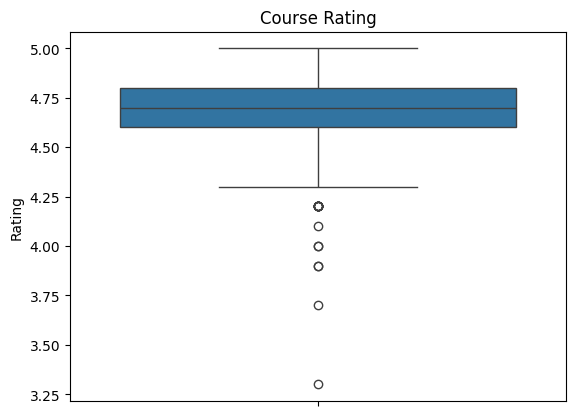

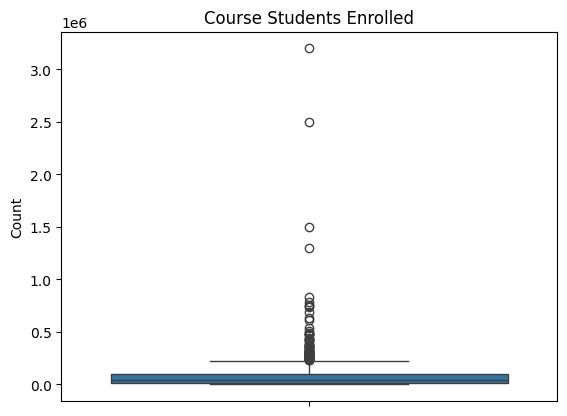

In [10]:
sns.boxplot(y=course_data["course_rating"])
plt.title("Course Rating")
plt.ylabel("Rating")
plt.show()

sns.boxplot(y=course_data["course_students_enrolled"])
plt.title("Course Students Enrolled")
plt.ylabel("Count")
plt.show()

##### Then I check the count of upper and lower outliers based on the IQR. To get IQR, I compute 25th and 75th precentiles with .quantile(). Then I define lower and upper fences at 1.5 (50%) x IQR below q1 and above q3. With boolean mask I look for outliers: values, that are outside the fences. Then I take a sum per column to have an overview of how much of outliers I have there.

In [11]:
q1 = outliers_check.quantile(0.25)
q3 = outliers_check.quantile(0.75)
iqr = q3 - q1

lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

outliers_filter = (outliers_check < lower_fence) | (outliers_check > upper_fence)

outliers_filter.sum()

course_rating               17
course_students_enrolled    78
dtype: int64

##### After identifying the presence of outliers, two additional plots are used to better understand the distribution of values. A histogram is used to show how course ratings are distributed, revealing how tightly clustered they are around the upper range. For student enrollment, a log-scaled boxplot is used to more clearly visualize the spread of values across several orders of magnitude, since raw enrollment counts are highly skewed.

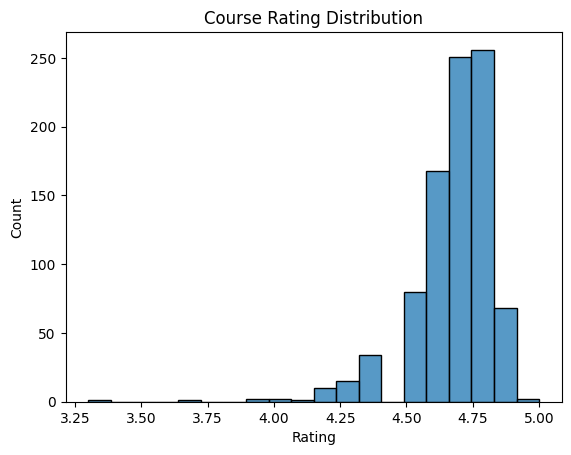

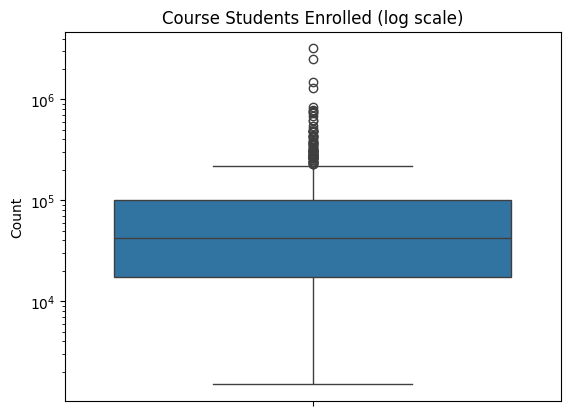

In [12]:
sns.histplot(course_data["course_rating"], bins=20, kde=False)
plt.title("Course Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

sns.boxplot(data=course_data, y="course_students_enrolled", showfliers=True)
plt.yscale("log")
plt.title("Course Students Enrolled (log scale)")
plt.ylabel("Count")
plt.show()

##### Outliers are not removed or changed because they are meaningful. Some courses have millions of students, it is expected on a platform like Coursera. These high enrollment courses represent actual user interest and are important for analysis. Instead of removing them, a log scale and median values are used in the plots to reduce their impact without losing important information.

# 2. Exploratory Data Analysis

### 2.1 Distribution of courses by certificate type:

##### The number of courses for each certificate type is counted and visualized with a bar chart. This helps identify which types of certificates are most commonly offered across the platform.

In [13]:
certificate_count = course_data["course_certificate_type"].value_counts()
certificate_count

course_certificate_type
COURSE                      582
SPECIALIZATION              297
PROFESSIONAL CERTIFICATE     12
Name: count, dtype: int64

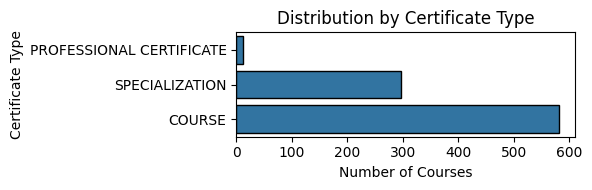

In [14]:
certificate_count = certificate_count.sort_values(ascending=True).reset_index()

certificate_count.columns = ["certificate_type", "course_count"]

plt.figure(figsize=(6, 2))
sns.barplot(
    data=certificate_count,
    x="course_count",
    y="certificate_type",
    edgecolor="k",
)
plt.title("Distribution by Certificate Type")
plt.xlabel("Number of Courses")
plt.ylabel("Certificate Type")
plt.tight_layout()
plt.show()

##### Takeaway: almost all content is single courses. Full, professional certificate paths are rare.

### 2.2 Distribution of courses by difficulty level:

##### The dataset is organized by course difficulty to see how many courses fall into each level. A horizontal bar chart is used for better readability.

In [15]:
difficulty_count = course_data["course_difficulty"].value_counts()
difficulty_count

course_difficulty
Beginner        487
Intermediate    198
Mixed           187
Advanced         19
Name: count, dtype: int64

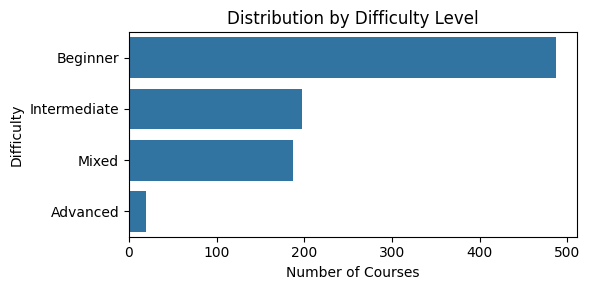

In [16]:
plt.figure(figsize=(6, 3))
sns.barplot(x=difficulty_count.values, y=difficulty_count.index)
plt.title("Distribution by Difficulty Level")
plt.xlabel("Number of Courses")
plt.ylabel("Difficulty")
plt.tight_layout()
plt.show()

##### Takeaway: most courses target beginners. Intermediate and mixed levels are fewer, and advanced courses are very rare.

### 2.3 Top 10 course providers by course count:

##### This gives an overview of which institutions are most active on the platform.

In [17]:
top_10 = (
    course_data["course_organization"].value_counts().head(10).to_frame("Course count")
)
top_10

,Course count
course_organization,
University of Pennsylvania,59
University of Michigan,41
Google Cloud,34
Duke University,28
Johns Hopkins University,28
"University of California, Irvine",27
IBM,22
University of Illinois at Urbana-Champaign,22
"University of California, Davis",21


In [26]:
count = top_10.sum()
count

Course count    301
dtype: int64

##### Takeaway: a handful of institutions dominate Coursera’s catalog. Ten institutions deliver 301 out of 891 courses (~34%)

### 2.4 Distribution of course ratings by difficulty

##### Stripplot is used to show the spread of course ratings for each difficulty level.

In [19]:
stats = course_data.groupby("course_difficulty")["course_rating"].describe()
stats

,count,mean,std,min,25%,50%,75%,max
course_difficulty,,,,,,,,
Advanced,19.000,4.600,0.194,4.200,4.500,4.700,4.750,4.900
Beginner,487.000,4.681,0.142,4.100,4.600,4.700,4.800,5.000
Intermediate,198.000,4.646,0.189,3.700,4.600,4.700,4.800,5.000
Mixed,187.000,4.709,0.171,3.300,4.600,4.800,4.800,4.900


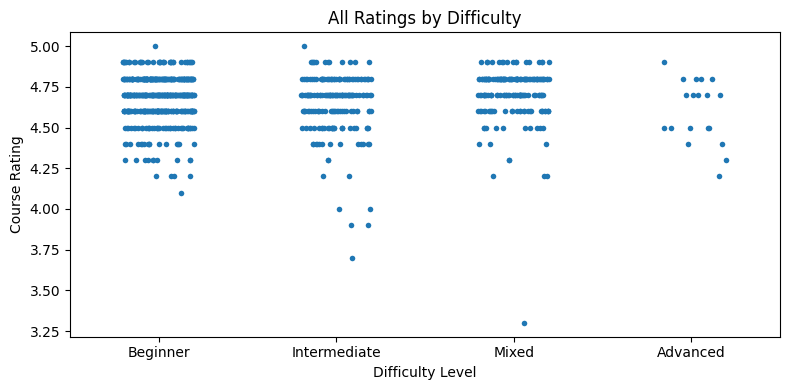

In [20]:
plt.figure(figsize=(8, 4))
sns.stripplot(
    data=course_data, x="course_difficulty", y="course_rating", jitter=0.2, size=4
)
plt.title("All Ratings by Difficulty")
plt.xlabel("Difficulty Level")
plt.ylabel("Course Rating")
plt.tight_layout()
plt.show()

##### Takeaway: course ratings are tightly clustered across all difficulty levels, mostly between 4.5 and 4.8, with few outliers. There is no meaningful difference in average rating between Beginner, Intermediate, and Mixed courses. Even Advanced courses, though fewer, follow the same pattern. This suggests that course difficulty has little to no impact on learner satisfaction. Ratings remain uniformly high.

### 2.5 Median student enrollment by difficulty

##### Barplot with median as the estimator is used to compare student enrollment across difficulty levels. A log scale is applied to handle the strong skew in enrollment values.

In [21]:
stats = course_data.groupby("course_difficulty")["course_students_enrolled"].describe()
stats

,count,mean,std,min,25%,50%,75%,max
course_difficulty,,,,,,,,
Advanced,19.000,"66,547.368","82,262.212","3,500.000","14,000.000","39,000.000","64,000.000","320,000.000"
Beginner,487.000,"81,974.949","127,270.771","1,500.000","15,000.000","37,000.000","98,500.000","1,500,000.000"
Intermediate,198.000,"73,264.141","104,206.139","1,600.000","14,000.000","37,000.000","79,750.000","690,000.000"
Mixed,187.000,"133,633.155","318,544.976","2,300.000","35,000.000","62,000.000","120,000.000","3,200,000.000"


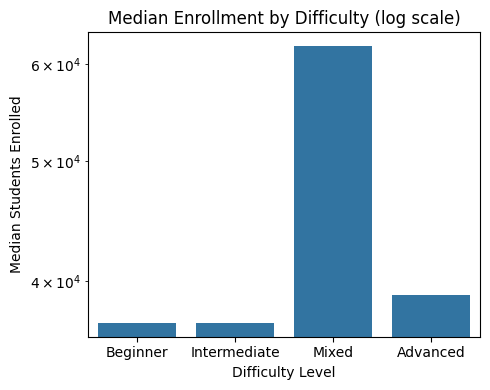

In [22]:
plt.figure(figsize=(5, 4))
sns.barplot(
    data=course_data,
    x="course_difficulty",
    y="course_students_enrolled",
    estimator=np.median,
    errorbar=None,
)
plt.yscale("log")
plt.title("Median Enrollment by Difficulty (log scale)")
plt.xlabel("Difficulty Level")
plt.ylabel("Median Students Enrolled")
plt.tight_layout()
plt.show()

##### Takeaway: courses labeled as Mixed difficulty have the highest median student enrollment by a large margin. This suggests that courses marked as “Mixed” tend to attract broader audiences, while difficulty-specific courses see much lower engagement.

### 2.6 Average course rating by certificate type:

##### The average rating for each certificate type is shown using a horizontal bar chart. The x-axis range is limited to focus on subtle differences.

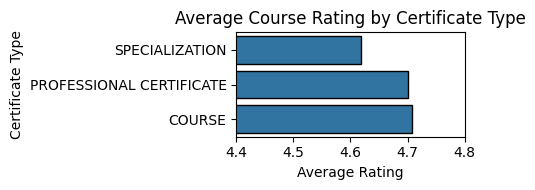

In [23]:
mean_ratings = (
    course_data.groupby("course_certificate_type")["course_rating"]
    .mean()
    .reset_index()
    .sort_values(by="course_rating", ascending=True)
)

plt.figure(figsize=(5, 2))
sns.barplot(
    data=mean_ratings, x="course_rating", y="course_certificate_type", edgecolor="k"
)
plt.xlim(4.4, 4.8)
plt.xlabel("Average Rating")
plt.ylabel("Certificate Type")
plt.title("Average Course Rating by Certificate Type")
plt.tight_layout()
plt.show()

##### Takeway: all certificate types have similarly high average ratings. The differences are small, and overall ratings are tightly clustered, suggesting that there are no quality inconsistencies between the focus of the courses.

### 2.7 Median student enrollment by certificate type

##### Median student enrollment is plotted for each certificate type. A log scale is used to account for highly skewed enrollment values.

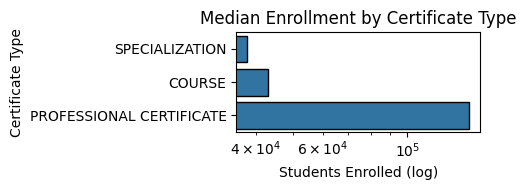

In [24]:
median_enroll = (
    course_data.groupby("course_certificate_type")["course_students_enrolled"]
    .median()
    .reset_index()
    .sort_values(by="course_students_enrolled", ascending=True)
)

plt.figure(figsize=(5, 2))
sns.barplot(
    data=median_enroll,
    x="course_students_enrolled",
    y="course_certificate_type",
    edgecolor="k",
)

plt.xscale("log")
plt.xlabel("Students Enrolled (log)")
plt.ylabel("Certificate Type")
plt.title("Median Enrollment by Certificate Type")
plt.tight_layout()
plt.show()

##### Takeaway: professional certificates have the highest median student enrollment by a wide margin. This may reflect stronger market demand for job-oriented content.

### 2.8 Relationship between course rating and enrollment

##### Scatter plot is used to explore the relationship between course rating and number of students enrolled. A log scale is applied to the y-axis. Pearson correlation is calculated and displayed to check the strength of the relationship.

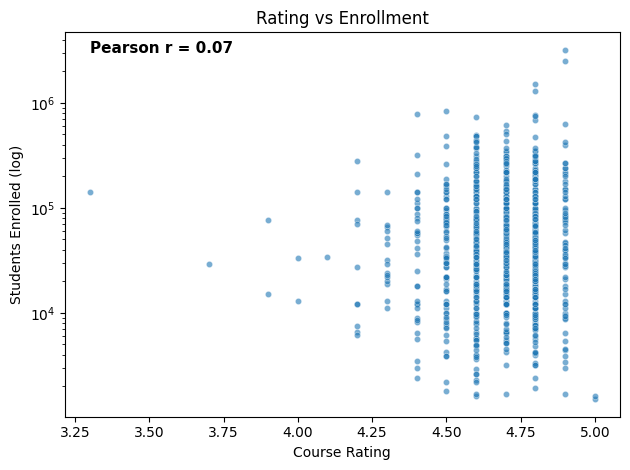

In [25]:
sns.scatterplot(
    data=course_data, x="course_rating", y="course_students_enrolled", s=20, alpha=0.6
)
plt.yscale("log")
plt.title("Rating vs Enrollment")

r = course_data[["course_rating", "course_students_enrolled"]].corr().iloc[0, 1]
plt.text(3.3, 3000000, f"Pearson r = {r:.2f}", fontsize=11, weight="bold")

plt.xlabel("Course Rating")
plt.ylabel("Students Enrolled (log)")
plt.tight_layout()
plt.show()

##### Takeaway: there is no meaningful correlation between course rating and number of students enrolled (Pearson r = 0.07). Ratings aren’t what attract students. Instead, they enroll based on topic, institution, certificate type, difficulty level.

# Conclusion

##### Course ratings across the platform are consistently high: 4.6 and 4.9 regardless of difficulty level or certificate type. This tight clustering indicates that ratings alone do not meaningfully differentiate courses.

##### In contrast, student enrollment shows far more variation. Median enrollment is significantly higher for courses labeled as "Mixed" difficulty and for those offering professional certificates. This suggests that mixed difficulty and career-oriented content attracts broader audiences.

##### There is no meaningful correlation between course ratings and enrollment numbers (Pearson r = 0.07). There is no real connection between how highly a course is rated and how many people take it.

##### Overall, the analysis highlights that while most Coursera courses receive similarly positive feedback, student engagement varies sharply depending on difficulty labeling and certificate type.

## Suggestions for future improvement:

##### To deepen the analysis, a few additional steps could be taken. First, we could compare course enrollment across top course providers to see which institutions tend to attract the most students. A bar chart showing median enrollment per provider would reveal useful patterns.

##### Secondly, we could analyze course ratings by provider to see if certain institutions consistently offer higher-rated content.

##### Lastly, we could check if some institutions mostly offer advanced courses or certain types of certificates. This could show what each provider focuses on or is known for.
